## 数据回归分析

In [95]:
from datetime import datetime, timedelta
import statsmodels.api as sm
import numpy as np
import pandas as pd
from model.db import DB_ENGINE

#### 构建时间块

In [138]:
labels = 'before3，before2，before1，issue，exchange，after1，after2，after3'.split('，')

start = datetime(2018, 7, 18)
delta = timedelta(weeks=1)

TimeBoxes = []

for label in labels:
    TimeBoxes.append( (label, start, start+delta) )
    start += delta

START = TimeBoxes[0][1]
END = TimeBoxes[-1][-1]

START, END, TimeBoxes

(datetime.datetime(2018, 7, 18, 0, 0),
 datetime.datetime(2018, 9, 12, 0, 0),
 [('before3',
   datetime.datetime(2018, 7, 18, 0, 0),
   datetime.datetime(2018, 7, 25, 0, 0)),
  ('before2',
   datetime.datetime(2018, 7, 25, 0, 0),
   datetime.datetime(2018, 8, 1, 0, 0)),
  ('before1',
   datetime.datetime(2018, 8, 1, 0, 0),
   datetime.datetime(2018, 8, 8, 0, 0)),
  ('issue',
   datetime.datetime(2018, 8, 8, 0, 0),
   datetime.datetime(2018, 8, 15, 0, 0)),
  ('exchange',
   datetime.datetime(2018, 8, 15, 0, 0),
   datetime.datetime(2018, 8, 22, 0, 0)),
  ('after1',
   datetime.datetime(2018, 8, 22, 0, 0),
   datetime.datetime(2018, 8, 29, 0, 0)),
  ('after2',
   datetime.datetime(2018, 8, 29, 0, 0),
   datetime.datetime(2018, 9, 5, 0, 0)),
  ('after3',
   datetime.datetime(2018, 9, 5, 0, 0),
   datetime.datetime(2018, 9, 12, 0, 0))])

In [139]:
df = pd.read_sql(
    'SELECT p.pid, p.blockid, p.replycount, p.remarkcount,r.upCount, LENGTH(r.content) lencontent, r.posttime FROM posts p, replys r WHERE p.pid=r.pid AND r.replyid=0', 
    DB_ENGINE, 
    index_col='pid', 
    parse_dates=['posttime']
)
df.head()

,blockid,replycount,remarkcount,upCount,lencontent,posttime
pid,,,,,,
1,1179,6,1,0,75,2018-07-15 00:47:55
2,1179,6,2,0,96,2018-07-15 06:38:52
3,1179,4,2,1,340,2018-07-15 15:10:31
4,1179,5,2,0,888,2018-07-16 09:03:09
5,1179,1,1,0,1253,2018-07-16 10:08:26


In [158]:
data_hist = df[df['posttime'].apply(lambda pt: pt>START and pt<END)].copy()

def posttime_descret(pt):
    for index, (label, start, end) in enumerate(TimeBoxes):
        if pt > start and pt < end:
            return '{}_{}'.format(index, label)
    return 'invalid'

data_hist['period'] = data_hist['posttime'].apply(posttime_descret)
data_hist = data_hist.groupby(data_hist['period']).mean()
data_hist

,replycount,remarkcount,upCount,lencontent
period,,,,
0_before3,44.470699,7.006198,0.520098,1119.760331
1_before2,56.833739,11.161773,1.203666,1082.518609
2_before1,82.304848,8.622537,4.269205,1147.683861
3_issue,85.240181,9.750793,16.388387,831.310442
4_exchange,96.146855,10.521254,15.444797,813.831795
5_after1,89.504855,9.950179,22.930441,809.174900
6_after2,75.970422,9.422193,16.568387,832.612660
7_after3,76.269487,10.947331,15.181882,904.289150


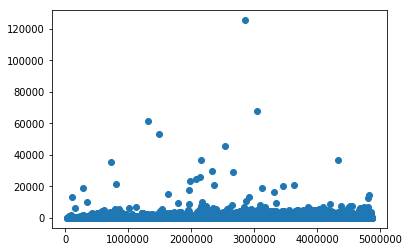

In [157]:
plt.

使用**帖子长度**和**楼主回帖数**和**板块**的虚拟变量作为控制变量，使用robust命令解决异方差的问题，以**天涯分发行和交易的时间**生成虚拟变量，考虑到论坛的活跃度可能与工作日和周末有关，所以取2018年7月18日到9月12日共8周的数据，将7月18日到8月1日两周作为基准，将后六周生成六个虚拟变量before，issue，exchange，after1，after2，after3。分别分析发行和可交易天涯分

#### 构建回归数据

In [98]:
data = df.copy()
for (label, start, end) in TimeBoxes:
    data[label] = data['posttime'].apply(lambda pt: pt > start and pt < end)

data = data.merge(pd.get_dummies(df['blockid']), on='pid')

data.head()

,blockid,replycount,remarkcount,upCount,lencontent,posttime,before3,before2,before1,issue,exchange,after1,after2,after3,1179,develop,free,funinfo,worldlook
pid,,,,,,,,,,,,,,,,,,,
1,1179,6,1,0,75,2018-07-15 00:47:55,False,False,False,False,False,False,False,False,1,0,0,0,0
2,1179,6,2,0,96,2018-07-15 06:38:52,False,False,False,False,False,False,False,False,1,0,0,0,0
3,1179,4,2,1,340,2018-07-15 15:10:31,False,False,False,False,False,False,False,False,1,0,0,0,0
4,1179,5,2,0,888,2018-07-16 09:03:09,False,False,False,False,False,False,False,False,1,0,0,0,0
5,1179,1,1,0,1253,2018-07-16 10:08:26,False,False,False,False,False,False,False,False,1,0,0,0,0


In [99]:
validdf = data[data['posttime'].apply(lambda pt: pt>START and pt<END)]
validdf.head()

,blockid,replycount,remarkcount,upCount,lencontent,posttime,before3,before2,before1,issue,exchange,after1,after2,after3,1179,develop,free,funinfo,worldlook
pid,,,,,,,,,,,,,,,,,,,
40,1179,2,1,0,631,2018-07-18 11:06:12,True,False,False,False,False,False,False,False,1,0,0,0,0
41,1179,3,1,2,1333,2018-07-18 11:22:13,True,False,False,False,False,False,False,False,1,0,0,0,0
42,1179,5,5,0,113,2018-07-18 11:22:31,True,False,False,False,False,False,False,False,1,0,0,0,0
43,1179,2,1,0,1160,2018-07-18 11:52:30,True,False,False,False,False,False,False,False,1,0,0,0,0
44,1179,2,1,0,3861,2018-07-18 12:07:57,True,False,False,False,False,False,False,False,1,0,0,0,0


#### 回归

In [100]:
X = np.column_stack((
    validdf['before1'].values,
    validdf['issue'].values,
    validdf['exchange'].values,
    validdf['after1'].values,
    validdf['after2'].values,
    validdf['after3'].values,
    validdf['lencontent'].values,
    validdf['develop'].values,
    validdf['free'].values,
    validdf['funinfo'].values,
    validdf['worldlook'].values,
    validdf['remarkcount'].values
))
xname=[
    'before1',
    'issue',
    'exchange',
    'after1',
    'after2',
    'after3',
    'lencontent',
    'develop',
    'free',
    'funinfo',
    'worldlook',
    'remarkcount',
    'constant'
]
X = sm.add_constant(X, prepend=False)
X

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 5., 1.],
       ...,
       [0., 0., 0., ..., 1., 7., 1.],
       [0., 0., 0., ..., 1., 3., 1.],
       [0., 0., 0., ..., 1., 2., 1.]])

In [122]:
rc = np.array(validdf['replycount'])
rc_model = sm.RLM(rc, X, M=sm.robust.norms.LeastSquares()).fit()
rc_model.summary(yname='replycount', xname=xname)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:             replycount   No. Observations:                65266
Model:                            RLM   Df Residuals:                    65253
Method:                          IRLS   Df Model:                           12
Norm:                    LeastSquares                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 12 Dec 2018                                         
Time:                        19:33:11                                         
No. Iterations:                     2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
before1        32.0865     12.088      2.654      0.008       8.395      55.778
issue          21.6964     10.258      2.115      0.034       1.592      41.801
exchange       27.7532      9.653      2.875      0.004       8.833      46.673
after1         26.3482      9.762      2.699      0.007       7.214      45.482
after2         16.6363      9.459      1.759      0.079      -1.902      35.175
after3          5.2841      9.355      0.565      0.572     -13.052      23.620
lencontent      0.0009      0.002      0.466      0.641      -0.003       0.005
develop        -9.5459      8.090     -1.180      0.238     -25.401       6.309
free          -42.0076      7.578     -5.543      0.000     -56.860     -27.155
funinfo         6.7803     10.208      0.664      0.507     -13.227      26.788
worldlook       2.4669     10.564      0.234      0.815     -18.238      23.171
remarkcount     5.6822      0.030    188.069      0.000       5.623       5.741
constant       20.9163      9.366      2.233      0.026       2.560      39.273
===============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [108]:
uc = np.array(validdf['upCount'])
uc_model = sm.RLM(uc, X, M=sm.robust.norms.LeastSquares()).fit()
uc_model.summary(yname='upCount', xname=xname)

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                upCount   No. Observations:                65266
Model:                            RLM   Df Residuals:                    65253
Method:                          IRLS   Df Model:                           12
Norm:                    LeastSquares                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 12 Dec 2018                                         
Time:                        19:09:45                                         
No. Iterations:                     2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
before1         2.8688      1.349      2.127      0.033       0.226       5.512
issue          12.0032      1.144     10.489      0.000       9.760      14.246
exchange       10.7634      1.077      9.995      0.000       8.653      12.874
after1         19.0909      1.089     17.530      0.000      16.956      21.225
after2         13.1389      1.055     12.452      0.000      11.071      15.207
after3         10.7207      1.044     10.272      0.000       8.675      12.766
lencontent     -0.0001      0.000     -0.528      0.598      -0.001       0.000
develop        -3.8035      0.902     -4.215      0.000      -5.572      -2.035
free          -13.4644      0.845    -15.926      0.000     -15.121     -11.807
funinfo        -3.0708      1.139     -2.697      0.007      -5.303      -0.839
worldlook      -3.6373      1.178     -3.086      0.002      -5.947      -1.327
remarkcount     0.1735      0.003     51.468      0.000       0.167       0.180
constant        8.0751      1.045      7.729      0.000       6.027      10.123
===============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

#### 作图

In [32]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt

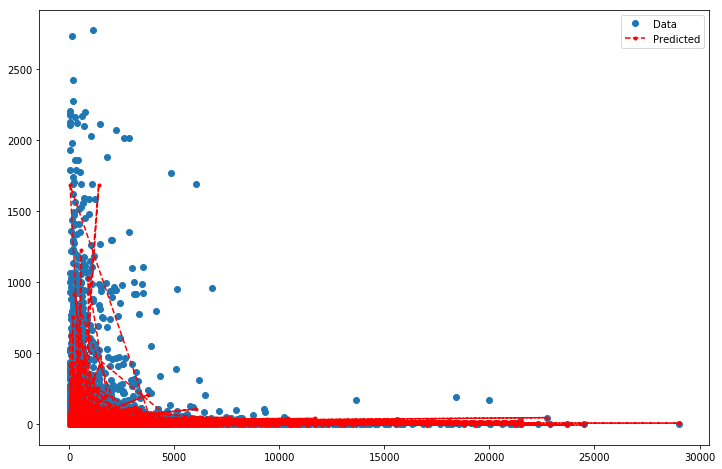

In [130]:
fig, ax = plt.subplots(figsize=(12,8))

x = validdf['lencontent']

ax.plot(x, uc, 'o', label="Data")

ax.plot(x, uc_model.fittedvalues, 'r--.', label="Predicted")

legend = ax.legend(loc="best")

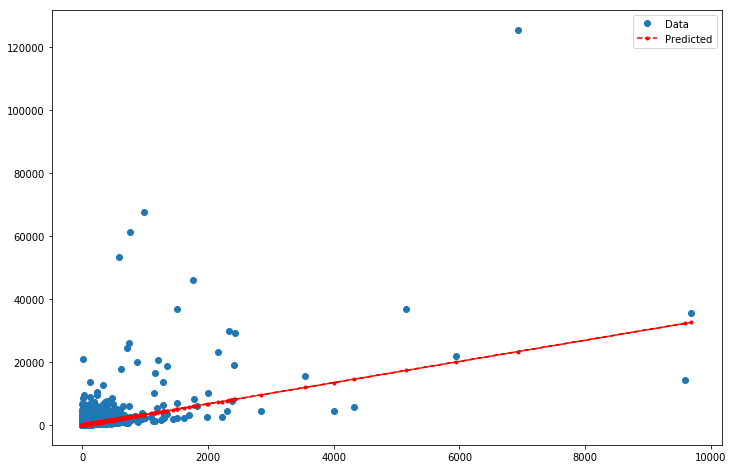

In [128]:
fig, ax = plt.subplots(figsize=(12,8))

x = validdf['remarkcount']
rc = np.array(validdf['replycount'])

ax.plot(x, y, 'o', label="Data")
ax.plot(x, model.fittedvalues, 'r--.', label="Predicted")

legend = ax.legend(loc="best")